# Import file

In [1]:
import pandas as pd
data_path = '/home/jeanchristophe/dataFolder/ppty_goldset/goldset_dedup_grouped.csv'
gold_set = pd.read_csv(data_path)
data_path = '/home/jeanchristophe/dataFolder/ppty_goldset/mapping_id_tag.xlsx'
tag_id_mapping = pd.read_excel(data_path)

/home/jeanchristophe/.pyenv/versions/3.7.7/envs/doublons3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/jeanchristophe/.pyenv/versions/3.7.7/envs/doublons3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
gold_set

,idannonce,cp,ville,codeinsee,descriptif_fr,px,surface,annee_construct,nb_pieces,latitude,...,districts_name,region_id,min_px,max_px,min_surface,max_surface,min_nbpiece,max_nbpiece,groups,len_group
0,152917265,38100,Grenoble,380185.0,grenoble allee de la pelouse en bordure du par...,88000.0,80.08,NaN,4.0,45.162621,...,Arlequin,252,84920.00,91080.00,77.6776,82.4824,3.0,5.0,"[152715315, 137918345, 152656465, 154105923]",4
1,151210099,38100,Grenoble,380185.0,era immobilier gresivaudan a trouve pour vous ...,158970.0,70.00,1960.0,3.0,45.180660,...,Allies-Clos d'Or,252,153406.05,164533.95,67.9000,72.1000,2.0,4.0,"[150604827, 147897763, 142827435, 145299099, 1...",5
2,150907823,38130,Échirolles,380151.0,iad france sophie armand vous propose echiroll...,125000.0,63.00,1970.0,4.0,45.147226,...,Comboire,252,120625.00,129375.00,61.1100,64.8900,3.0,5.0,"[151785547, 152595879, 154223735, 152288085]",4
3,148550245,38000,Grenoble,380185.0,appartement residence etudiante marie curie de...,67000.0,18.00,NaN,1.0,45.194349,...,Berriat-Ampere,252,64655.00,69345.00,17.4600,18.5400,0.0,2.0,[],0
4,152658935,38400,Saint Martin d Heres,380421.0,secteur parc jo blanchon au calme et proche tr...,199000.0,99.00,NaN,6.0,45.173628,...,Renaudie-La Plaine,252,192035.00,205965.00,96.0300,101.9700,5.0,7.0,[151928147],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3783,152968579,75017,Paris 17ème,750117.0,marche lebon grand pieces renove de m dans imm...,667800.0,53.00,1900.0,2.0,NaN,...,NaN,239,644427.00,691173.00,51.4100,54.5900,1.0,3.0,"[154419047, 145808105]",2
3784,145561525,93400,St Ouen,930070.0,laforet saint ouen dans le quartier recherche ...,525000.0,86.80,NaN,4.0,NaN,...,NaN,239,506625.00,543375.00,84.1960,89.4040,3.0,5.0,"[145549993, 153617397, 154032987]",3
3785,154196547,93400,Saint-Ouen,930070.0,frais de notaire reduits au coeur de la ville ...,574000.0,86.00,NaN,4.0,NaN,...,NaN,239,553910.00,594090.00,83.4200,88.5800,3.0,5.0,"[154687809, 154195899, 154196199, 154195963]",4
3786,148814785,93200,Saint-Denis,930066.0,appartement pieces proche de la place du mai d...,165000.0,50.00,1970.0,2.0,NaN,...,NaN,239,159225.00,170775.00,48.5000,51.5000,1.0,3.0,[],0


In [14]:
max(gold_set['len_group'])

32

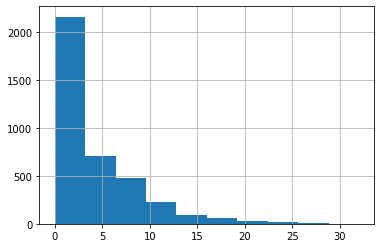

In [16]:
gold_set['len_group'].hist()

In [4]:
import requests
import numpy as np
import copy

def tag_to_cdn(photo_tag, width = 300):
    if isinstance(photo_tag, str):
        url = f"https://v.seloger.com/s/width/{width}/visuels/{'/'.join(photo_tag[:4])}/{photo_tag}.jpg"
        return url
        
def id_to_tag(ads_id, mapping):
    return mapping[mapping.idannonce==ads_id]['tagphoto'].values.tolist()

def id_to_cdn(ads_id, mapping):
    cdn_list = []
    for tag in id_to_tag(ads_id, mapping):
        cdn_list.append(tag_to_cdn(tag))
    return cdn_list

def check_jsonl(line):
    # Get list of image-url
    if len(line['images'])==0:
        return False
    option_list = copy.deepcopy(line['options'])
    for opt in line['options']:
        if len(opt['images'])==0:
            option_list.remove(opt)
    if len(option_list)==0:
        return False
    else:
        line['options'] = option_list
        return line
    

In [5]:
json_line_list = []
for ind, row in gold_set.iterrows():
    
    line = {
        "id": str(row.idannonce),
        "text": row.descriptif_fr,
        "images": id_to_cdn(row.idannonce, tag_id_mapping)
    }
    # Remove
    
    options_list = []
    for id_linked in eval(row.groups):
        text_descriptif = gold_set[gold_set.idannonce==id_linked].descriptif_fr.values[0]
        options_dict = {
            "id": id_linked,
            "text": text_descriptif,
            "images": id_to_cdn(id_linked, tag_id_mapping)
        }
        options_list.append(options_dict)
    line["options"] = options_list
    if check_jsonl(line):
        json_line_list.append(line)
    print(f'{ind+1}/{gold_set.shape[0]}')
        

1/3788
2/3788
3/3788
4/3788
5/3788
6/3788
7/3788
8/3788
9/3788
10/3788
11/3788
12/3788
13/3788
14/3788
15/3788
16/3788
17/3788
18/3788
19/3788
20/3788
21/3788
22/3788
23/3788
24/3788
25/3788
26/3788
27/3788
28/3788
29/3788
30/3788
31/3788
32/3788
33/3788
34/3788
35/3788
36/3788
37/3788
38/3788
39/3788
40/3788
41/3788
42/3788
43/3788
44/3788
45/3788
46/3788
47/3788
48/3788
49/3788
50/3788
51/3788
52/3788
53/3788
54/3788
55/3788
56/3788
57/3788
58/3788
59/3788
60/3788
61/3788
62/3788
63/3788
64/3788
65/3788
66/3788
67/3788
68/3788
69/3788
70/3788
71/3788
72/3788
73/3788
74/3788
75/3788
76/3788
77/3788
78/3788
79/3788
80/3788
81/3788
82/3788
83/3788
84/3788
85/3788
86/3788
87/3788
88/3788
89/3788
90/3788
91/3788
92/3788
93/3788
94/3788
95/3788
96/3788
97/3788
98/3788
99/3788
100/3788
101/3788
102/3788
103/3788
104/3788
105/3788
106/3788
107/3788
108/3788
109/3788
110/3788
111/3788
112/3788
113/3788
114/3788
115/3788
116/3788
117/3788
118/3788
119/3788
120/3788
121/3788
122/3788
123/3788
1

952/3788
953/3788
954/3788
955/3788
956/3788
957/3788
958/3788
959/3788
960/3788
961/3788
962/3788
963/3788
964/3788
965/3788
966/3788
967/3788
968/3788
969/3788
970/3788
971/3788
972/3788
973/3788
974/3788
975/3788
976/3788
977/3788
978/3788
979/3788
980/3788
981/3788
982/3788
983/3788
984/3788
985/3788
986/3788
987/3788
988/3788
989/3788
990/3788
991/3788
992/3788
993/3788
994/3788
995/3788
996/3788
997/3788
998/3788
999/3788
1000/3788
1001/3788
1002/3788
1003/3788
1004/3788
1005/3788
1006/3788
1007/3788
1008/3788
1009/3788
1010/3788
1011/3788
1012/3788
1013/3788
1014/3788
1015/3788
1016/3788
1017/3788
1018/3788
1019/3788
1020/3788
1021/3788
1022/3788
1023/3788
1024/3788
1025/3788
1026/3788
1027/3788
1028/3788
1029/3788
1030/3788
1031/3788
1032/3788
1033/3788
1034/3788
1035/3788
1036/3788
1037/3788
1038/3788
1039/3788
1040/3788
1041/3788
1042/3788
1043/3788
1044/3788
1045/3788
1046/3788
1047/3788
1048/3788
1049/3788
1050/3788
1051/3788
1052/3788
1053/3788
1054/3788
1055/3788
1056/378

1777/3788
1778/3788
1779/3788
1780/3788
1781/3788
1782/3788
1783/3788
1784/3788
1785/3788
1786/3788
1787/3788
1788/3788
1789/3788
1790/3788
1791/3788
1792/3788
1793/3788
1794/3788
1795/3788
1796/3788
1797/3788
1798/3788
1799/3788
1800/3788
1801/3788
1802/3788
1803/3788
1804/3788
1805/3788
1806/3788
1807/3788
1808/3788
1809/3788
1810/3788
1811/3788
1812/3788
1813/3788
1814/3788
1815/3788
1816/3788
1817/3788
1818/3788
1819/3788
1820/3788
1821/3788
1822/3788
1823/3788
1824/3788
1825/3788
1826/3788
1827/3788
1828/3788
1829/3788
1830/3788
1831/3788
1832/3788
1833/3788
1834/3788
1835/3788
1836/3788
1837/3788
1838/3788
1839/3788
1840/3788
1841/3788
1842/3788
1843/3788
1844/3788
1845/3788
1846/3788
1847/3788
1848/3788
1849/3788
1850/3788
1851/3788
1852/3788
1853/3788
1854/3788
1855/3788
1856/3788
1857/3788
1858/3788
1859/3788
1860/3788
1861/3788
1862/3788
1863/3788
1864/3788
1865/3788
1866/3788
1867/3788
1868/3788
1869/3788
1870/3788
1871/3788
1872/3788
1873/3788
1874/3788
1875/3788
1876/3788


2603/3788
2604/3788
2605/3788
2606/3788
2607/3788
2608/3788
2609/3788
2610/3788
2611/3788
2612/3788
2613/3788
2614/3788
2615/3788
2616/3788
2617/3788
2618/3788
2619/3788
2620/3788
2621/3788
2622/3788
2623/3788
2624/3788
2625/3788
2626/3788
2627/3788
2628/3788
2629/3788
2630/3788
2631/3788
2632/3788
2633/3788
2634/3788
2635/3788
2636/3788
2637/3788
2638/3788
2639/3788
2640/3788
2641/3788
2642/3788
2643/3788
2644/3788
2645/3788
2646/3788
2647/3788
2648/3788
2649/3788
2650/3788
2651/3788
2652/3788
2653/3788
2654/3788
2655/3788
2656/3788
2657/3788
2658/3788
2659/3788
2660/3788
2661/3788
2662/3788
2663/3788
2664/3788
2665/3788
2666/3788
2667/3788
2668/3788
2669/3788
2670/3788
2671/3788
2672/3788
2673/3788
2674/3788
2675/3788
2676/3788
2677/3788
2678/3788
2679/3788
2680/3788
2681/3788
2682/3788
2683/3788
2684/3788
2685/3788
2686/3788
2687/3788
2688/3788
2689/3788
2690/3788
2691/3788
2692/3788
2693/3788
2694/3788
2695/3788
2696/3788
2697/3788
2698/3788
2699/3788
2700/3788
2701/3788
2702/3788


3450/3788
3451/3788
3452/3788
3453/3788
3454/3788
3455/3788
3456/3788
3457/3788
3458/3788
3459/3788
3460/3788
3461/3788
3462/3788
3463/3788
3464/3788
3465/3788
3466/3788
3467/3788
3468/3788
3469/3788
3470/3788
3471/3788
3472/3788
3473/3788
3474/3788
3475/3788
3476/3788
3477/3788
3478/3788
3479/3788
3480/3788
3481/3788
3482/3788
3483/3788
3484/3788
3485/3788
3486/3788
3487/3788
3488/3788
3489/3788
3490/3788
3491/3788
3492/3788
3493/3788
3494/3788
3495/3788
3496/3788
3497/3788
3498/3788
3499/3788
3500/3788
3501/3788
3502/3788
3503/3788
3504/3788
3505/3788
3506/3788
3507/3788
3508/3788
3509/3788
3510/3788
3511/3788
3512/3788
3513/3788
3514/3788
3515/3788
3516/3788
3517/3788
3518/3788
3519/3788
3520/3788
3521/3788
3522/3788
3523/3788
3524/3788
3525/3788
3526/3788
3527/3788
3528/3788
3529/3788
3530/3788
3531/3788
3532/3788
3533/3788
3534/3788
3535/3788
3536/3788
3537/3788
3538/3788
3539/3788
3540/3788
3541/3788
3542/3788
3543/3788
3544/3788
3545/3788
3546/3788
3547/3788
3548/3788
3549/3788


In [10]:
# import jsonlines

# nbr_element_in_task = 10

#with jsonlines.open('/home/jeanchristophe/dataFolder/ppty_goldset/task.jsonl', mode='w') as writer:
#    writer.write_all(json_line_list[:nbr_element_in_task])

In [13]:
with jsonlines.open('/home/jeanchristophe/dataFolder/ppty_goldset/task.jsonl', mode='w') as writer:
    writer.write_all(json_line_list)